<a href="https://colab.research.google.com/github/ValeriiYermak/DataScience/blob/main/%22HW_4_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

In [27]:
# Шлях до файлу на Google Drive
path = '/content/drive/My Drive/Colab Notebooks/HW_4/bikes_rent.csv'

# Читаємо CSV файл
df = pd.read_csv(path)

# Виводимо перші рядки DataFrame
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [28]:
df.shape

(731, 13)

In [29]:
df.dtypes

season              int64
yr                  int64
mnth                int64
holiday             int64
weekday             int64
workingday          int64
weathersit          int64
temp              float64
atemp             float64
hum               float64
windspeed(mph)    float64
windspeed(ms)     float64
cnt                 int64
dtype: object

In [30]:
df.isnull().sum()

season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
atemp             0
hum               0
windspeed(mph)    0
windspeed(ms)     0
cnt               0
dtype: int64

Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

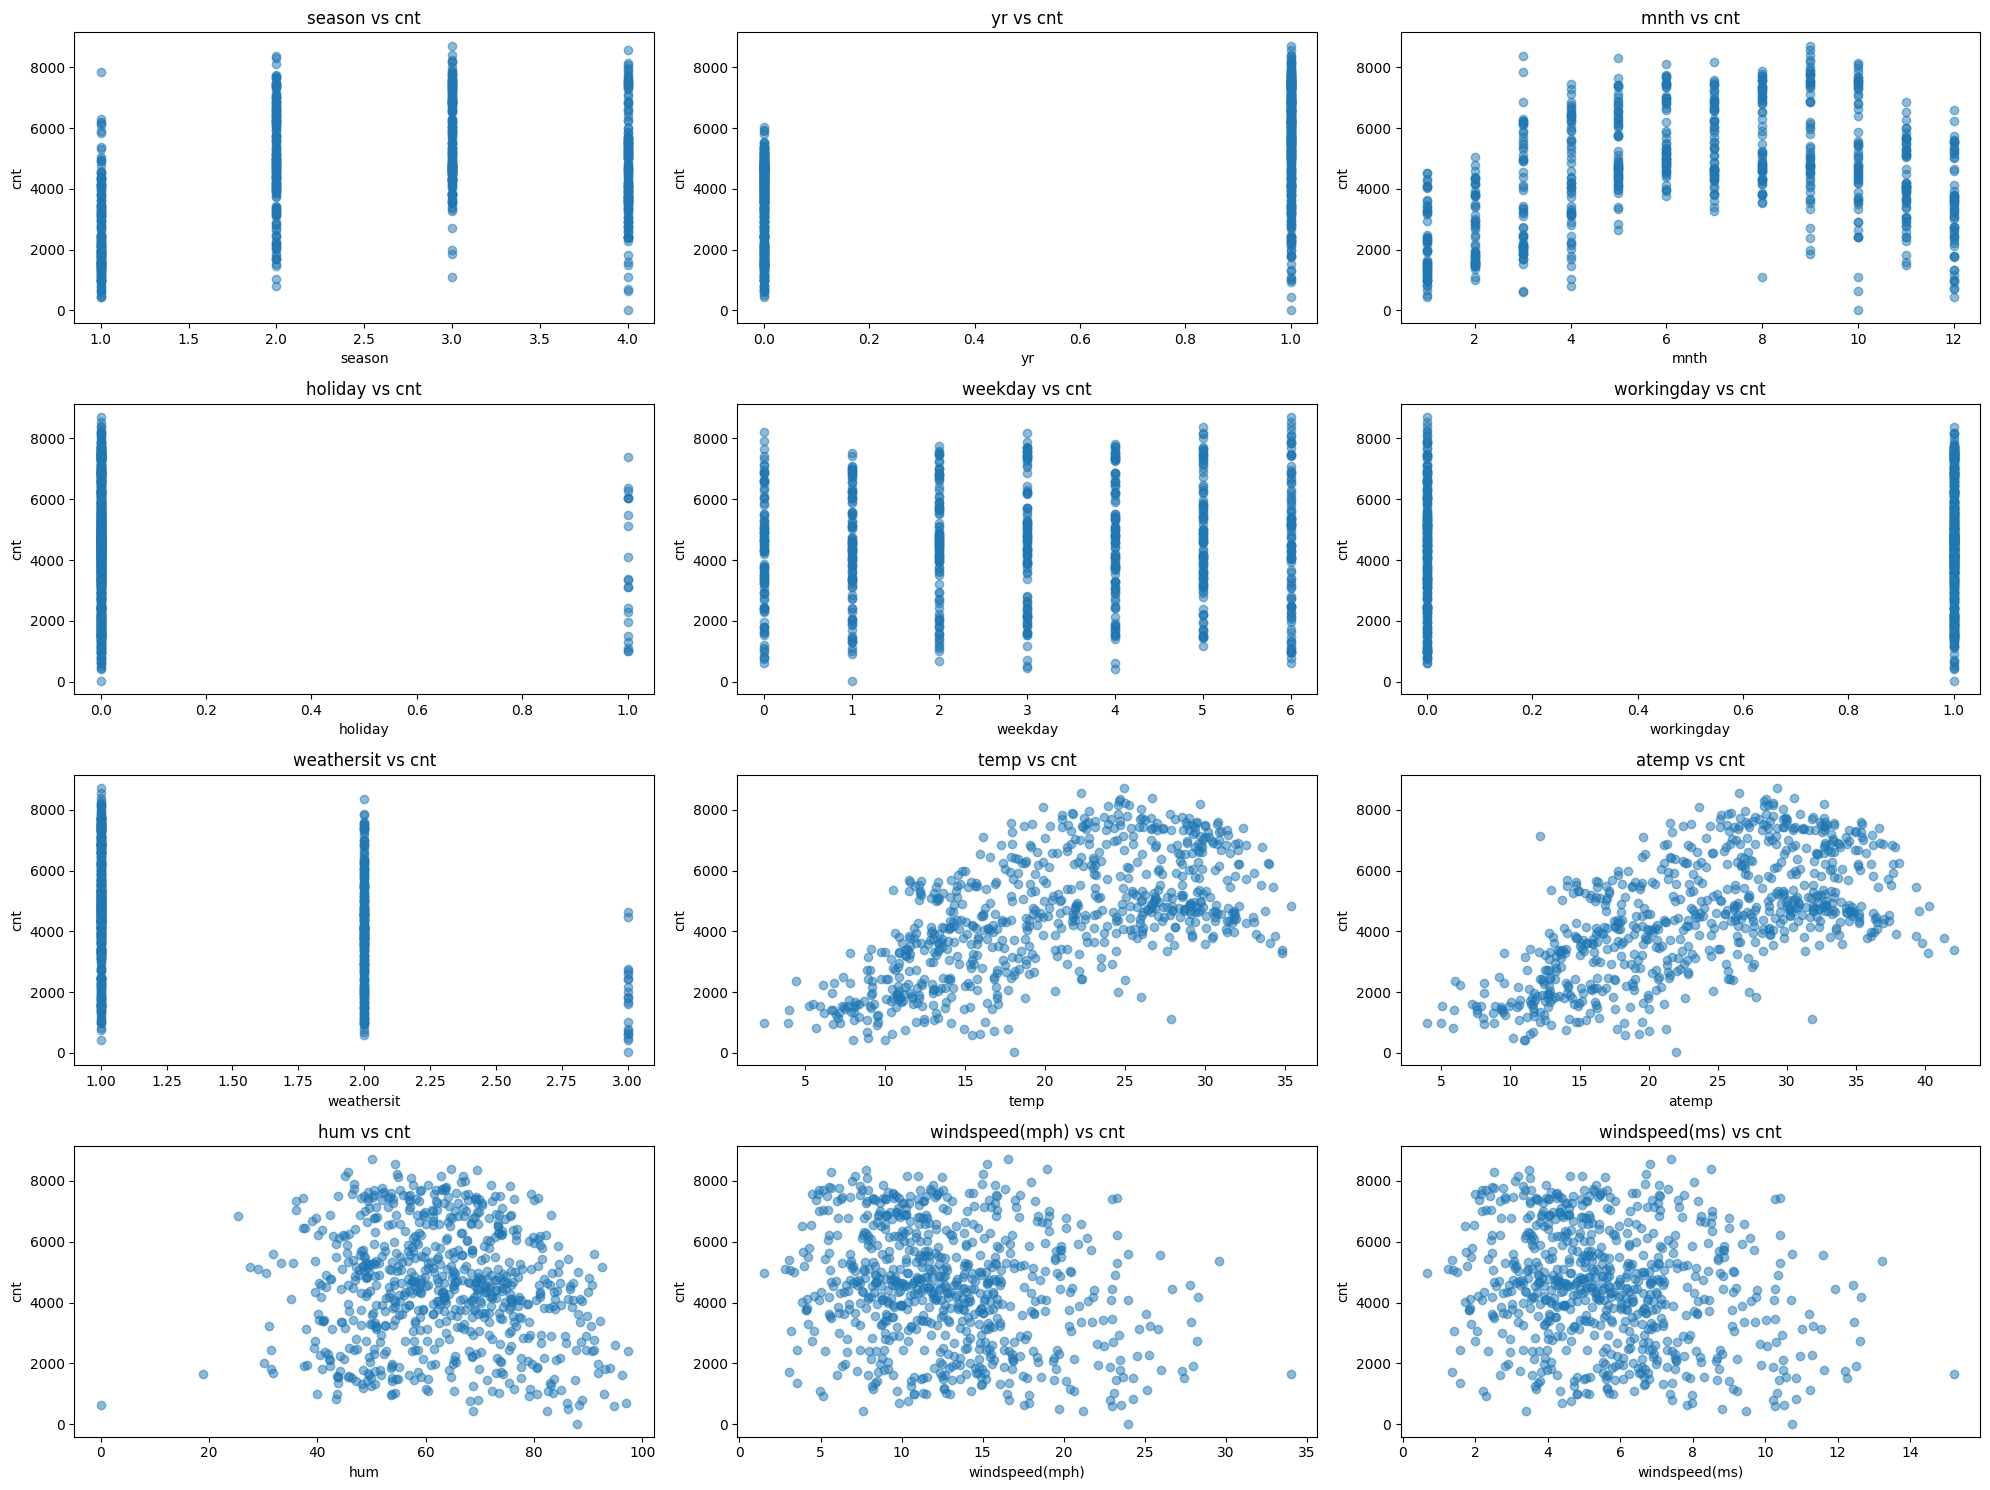

In [31]:
# Список атрибутів
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Створюємо 12 графіків
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 15))
axes = axes.flatten()

for i, attr in enumerate(attributes):
    axes[i].scatter(df[attr], df['cnt'], alpha=0.5)
    axes[i].set_title(f'{attr} vs cnt')
    axes[i].set_xlabel(attr)
    axes[i].set_ylabel('cnt')

plt.tight_layout()
plt.show()

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

**Аналізуючи графік можна сказати, що залежність проявляється в можливості насолоджуватися прокатом як таким, так як найменша кількість прокатів припадає на холодні місяці, що, ймовірно, викликано некомфортною подорожжю велосипедом в холодну погоду при низькій температурі та поганим станом засніжених доріг.**

## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [32]:
correlation_matrix = df.corr()
display(correlation_matrix)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046,0.406100
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817,0.566710
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502,0.279977
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292,-0.068348
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282,0.067443
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796,0.061156
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511,-0.297391
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659


In [33]:
target_column = df.columns[-1]
# Обчислюємо кореляцію всіх ознак, окрім останньої, з останньою
correlation_with_target = df.iloc[:, :-1].corrwith(df[target_column])

# Відображення результату
display(correlation_with_target)



season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [34]:
# Вибираємо тільки потрібні ознаки
features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
df_selected = df[features]

# Обчислюємо кореляційну матрицю між обраними ознаками
correlation_matrix = df_selected.corr()

display(correlation_matrix)

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

In [35]:
# Обчислюємо середні значення числових ознак
mean_values = df.mean()

display(mean_values)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

## Завдання 4

Виведіть середні ознак.

In [36]:
# Виведення середніх значень ознак
mean_values = df.mean()
display("Середні значення ознак:\n", mean_values)

'Середні значення ознак:\n'

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

In [37]:
# Стандартизування матриці об'єкти-ознаки
scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)

# Перетворення назад у DataFrame для зручності
normalized_df = pd.DataFrame(normalized_data, columns=df.columns)
display("Нормована матриця об'єкти-ознаки:\n", normalized_df)

"Нормована матриця об'єкти-ознаки:\n"

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,-1.348213,-1.001369,-1.600161,-0.171981,1.498809,-1.471225,1.110427,-0.826662,-0.679946,1.250171,-0.387892,-0.387892,-1.817953
1,-1.348213,-1.001369,-1.600161,-0.171981,-1.496077,-1.471225,1.110427,-0.721095,-0.740652,0.479113,0.749602,0.749602,-1.912999
2,-1.348213,-1.001369,-1.600161,-0.171981,-0.996930,0.679706,-0.726048,-1.634657,-1.749767,-1.339274,0.746632,0.746632,-1.629925
3,-1.348213,-1.001369,-1.600161,-0.171981,-0.497782,0.679706,-0.726048,-1.614780,-1.610270,-0.263182,-0.389829,-0.389829,-1.519898
4,-1.348213,-1.001369,-1.600161,-0.171981,0.001366,0.679706,-0.726048,-1.467414,-1.504971,-1.341494,-0.046307,-0.046307,-1.500269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.348213,0.998633,1.588660,-0.171981,0.500513,0.679706,1.110427,-1.318665,-1.521108,0.175807,2.061426,2.061426,-1.234757
727,-1.348213,0.998633,1.588660,-0.171981,0.999661,0.679706,1.110427,-1.323224,-1.346690,-0.266238,-0.452131,-0.452131,-0.728012
728,-1.348213,0.998633,1.588660,-0.171981,1.498809,-1.471225,1.110427,-1.323224,-1.424344,0.878392,-0.853552,-0.853552,-1.634057
729,-1.348213,0.998633,1.588660,-0.171981,-1.496077,-1.471225,-0.726048,-1.309558,-1.490049,-1.015664,2.069444,2.069444,-1.399023


In [38]:
df.shape

(731, 13)

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [39]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [40]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

In [41]:
# Перемішування вибірки
shuffled_df = normalized_df.sample(frac=1, random_state=42).reset_index(drop=True)
display("Перемішана вибірка:", shuffled_df)

# Поділ на навчальну і тестову вибірки для крос-валідації
X_train, X_test, y_train, y_test = train_test_split(
    normalized_df.drop(columns='cnt'),
    normalized_df['cnt'],
    test_size=0.2,
    random_state=42
)

display("Навчальна вибірка:", X_train)
display("Тестова вибірка:", X_test)

'Перемішана вибірка:'

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1.354375,0.998633,1.588660,-0.171981,-0.497782,0.679706,-0.726048,-0.106884,-0.032545,0.743727,-0.211211,-0.211211,1.085628
1,-1.348213,-1.001369,-1.310268,-0.171981,0.500513,0.679706,-0.726048,-1.686082,-1.820550,-1.335389,1.126812,1.126812,-1.526097
2,1.354375,-1.001369,1.008875,-0.171981,0.999661,0.679706,1.110427,-0.899555,-0.955126,-0.295514,0.503491,0.503491,-0.391216
3,-0.447350,0.998633,-0.730482,-0.171981,-1.496077,-1.471225,1.110427,-0.380219,-0.350427,0.339741,-0.235254,-0.235254,0.793772
4,1.354375,0.998633,0.718982,-0.171981,-0.497782,0.679706,-0.726048,0.298565,0.428770,-0.406755,0.591838,0.591838,1.567061
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.348213,-1.001369,-1.020375,-0.171981,-1.496077,-1.471225,-0.726048,-0.607005,-0.578834,-0.706119,1.034514,1.034514,-1.078240
727,-0.447350,-1.001369,-0.730482,-0.171981,-1.496077,-1.471225,-0.726048,-0.211658,-0.175978,-1.042010,1.459229,1.459229,-0.392765
728,1.354375,-1.001369,0.718982,-0.171981,0.001366,0.679706,1.110427,0.763234,0.619000,1.551700,-0.540478,-0.540478,-0.308566
729,-1.348213,0.998633,-1.020375,-0.171981,-1.496077,-1.471225,-0.726048,-0.730601,-0.704232,-1.060460,0.414499,0.414499,0.210059


'Навчальна вибірка:'

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
682,1.354375,0.998633,1.298767,-0.171981,-0.497782,0.679706,1.110427,-0.831221,-0.928028,0.246066,1.957003,1.957003
250,0.453512,-1.001369,0.718982,-0.171981,0.500513,0.679706,2.946901,0.757292,0.497434,2.189752,0.029205,0.029205
336,1.354375,-1.001369,1.588660,-0.171981,1.498809,-1.471225,-0.726048,-1.072664,-1.005528,-0.105227,-1.222843,-1.222843
260,0.453512,-1.001369,0.718982,-0.171981,-1.496077,-1.471225,-0.726048,0.066230,0.099374,0.471476,-0.154990,-0.154990
543,0.453512,0.998633,-0.150697,-0.171981,0.001366,0.679706,-0.726048,1.104903,1.022035,-1.882182,1.049635,1.049635
...,...,...,...,...,...,...,...,...,...,...,...,...
71,-1.348213,-1.001369,-1.020375,-0.171981,-1.496077,-1.471225,-0.726048,-0.607005,-0.578834,-0.706119,1.034514,1.034514
106,-0.447350,-1.001369,-0.730482,-0.171981,-1.496077,-1.471225,-0.726048,-0.211658,-0.175978,-1.042010,1.459229,1.459229
270,1.354375,-1.001369,0.718982,-0.171981,0.001366,0.679706,1.110427,0.763234,0.619000,1.551700,-0.540478,-0.540478
435,-1.348213,0.998633,-1.020375,-0.171981,-1.496077,-1.471225,-0.726048,-0.730601,-0.704232,-1.060460,0.414499,0.414499


'Тестова вибірка:'

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
703,1.354375,0.998633,1.588660,-0.171981,-0.497782,0.679706,-0.726048,-0.106884,-0.032545,0.743727,-0.211211,-0.211211
33,-1.348213,-1.001369,-1.310268,-0.171981,0.500513,0.679706,-0.726048,-1.686082,-1.820550,-1.335389,1.126812,1.126812
300,1.354375,-1.001369,1.008875,-0.171981,0.999661,0.679706,1.110427,-0.899555,-0.955126,-0.295514,0.503491,0.503491
456,-0.447350,0.998633,-0.730482,-0.171981,-1.496077,-1.471225,1.110427,-0.380219,-0.350427,0.339741,-0.235254,-0.235254
633,1.354375,0.998633,0.718982,-0.171981,-0.497782,0.679706,-0.726048,0.298565,0.428770,-0.406755,0.591838,0.591838
...,...,...,...,...,...,...,...,...,...,...,...,...
70,-1.348213,-1.001369,-1.020375,-0.171981,1.498809,-1.471225,-0.726048,-0.908663,-0.912522,-0.234038,0.391101,0.391101
192,0.453512,-1.001369,0.139196,-0.171981,-0.497782,0.679706,-0.726048,1.633352,1.626783,-0.482866,0.126126,0.126126
328,1.354375,-1.001369,1.298767,-0.171981,0.999661,0.679706,-0.726048,-0.658107,-0.575273,0.111401,-1.182653,-1.182653
165,-0.447350,-1.001369,-0.150697,-0.171981,0.001366,0.679706,-0.726048,0.717680,0.696348,-1.097627,-0.291488,-0.291488


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [42]:
from sklearn.linear_model import LinearRegression

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [43]:
# Стандартизація ознак
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Перетворення назад у DataFrame для зручності
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
#display("Стандартизована матриця об'єкти-ознаки:", scaled_df)

# Перемішування вибірки
shuffled_df = scaled_df.sample(frac=1, random_state=42).reset_index(drop=True)
#display("Перемішана вибірка:", shuffled_df)

# Поділ на навчальну і тестову вибірки
X = shuffled_df.drop(columns='cnt')
y = shuffled_df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Навчання моделі лінійної регресії
model = LinearRegression()
model.fit(X_train, y_train)

# Виведення ваг ознак
weights = pd.Series(model.coef_, index=X.columns)
display("Ваги ознак:", weights)

'Ваги ознак:'

season            2.998857e-01
yr                5.224852e-01
mnth             -8.673529e-02
holiday          -4.141927e-02
weekday           6.631090e-02
workingday        3.613499e-02
weathersit       -1.658229e-01
temp              2.187795e-01
atemp             2.993801e-01
hum              -7.755673e-02
windspeed(mph)    9.331319e+09
windspeed(ms)    -9.331319e+09
dtype: float64

## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [44]:
# Виведення ваг ознак у вигляді пар (назва ознаки, вага)
weights = zip(X.columns, model.coef_)
display("Ваги ознак:")
for feature, weight in weights:
    print(f"{feature}: {weight}")

'Ваги ознак:'

season: 0.29988574395414064
yr: 0.5224851525841545
mnth: -0.08673528761273974
holiday: -0.04141926729793369
weekday: 0.06631090050637739
workingday: 0.0361349919083572
weathersit: -0.16582292656426556
temp: 0.21877948531063912
atemp: 0.2993800941511425
hum: -0.07755672631579447
windspeed(mph): 9331318749.78246
windspeed(ms): -9331318749.88905


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Стандартизація ознак
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Перетворення назад у DataFrame для зручності
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
display("Стандартизована матриця об'єкти-ознаки:\n", scaled_df)

# Виділення ознак і цільової змінної
X = scaled_df.drop(columns='cnt')
y = scaled_df['cnt']

# Розділення даних на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


"Стандартизована матриця об'єкти-ознаки:\n"

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,-1.348213,-1.001369,-1.600161,-0.171981,1.498809,-1.471225,1.110427,-0.826662,-0.679946,1.250171,-0.387892,-0.387892,-1.817953
1,-1.348213,-1.001369,-1.600161,-0.171981,-1.496077,-1.471225,1.110427,-0.721095,-0.740652,0.479113,0.749602,0.749602,-1.912999
2,-1.348213,-1.001369,-1.600161,-0.171981,-0.996930,0.679706,-0.726048,-1.634657,-1.749767,-1.339274,0.746632,0.746632,-1.629925
3,-1.348213,-1.001369,-1.600161,-0.171981,-0.497782,0.679706,-0.726048,-1.614780,-1.610270,-0.263182,-0.389829,-0.389829,-1.519898
4,-1.348213,-1.001369,-1.600161,-0.171981,0.001366,0.679706,-0.726048,-1.467414,-1.504971,-1.341494,-0.046307,-0.046307,-1.500269
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.348213,0.998633,1.588660,-0.171981,0.500513,0.679706,1.110427,-1.318665,-1.521108,0.175807,2.061426,2.061426,-1.234757
727,-1.348213,0.998633,1.588660,-0.171981,0.999661,0.679706,1.110427,-1.323224,-1.346690,-0.266238,-0.452131,-0.452131,-0.728012
728,-1.348213,0.998633,1.588660,-0.171981,1.498809,-1.471225,1.110427,-1.323224,-1.424344,0.878392,-0.853552,-0.853552,-1.634057
729,-1.348213,0.998633,1.588660,-0.171981,-1.496077,-1.471225,-0.726048,-1.309558,-1.490049,-1.015664,2.069444,2.069444,-1.399023


Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [46]:
# Навчання моделі Lasso з меншим параметром α
lasso_model = Lasso(alpha=0.001)  # Зменшення параметра α
lasso_model.fit(X_train, y_train)

# Виведення ваг ознак для Lasso
lasso_weights = zip(X.columns, lasso_model.coef_)
lasso_output = "Ваги ознак (Lasso):\n"
for feature, weight in lasso_weights:
    lasso_output += f"{feature}: {weight}\n"
print(lasso_output)

Ваги ознак (Lasso):
season: 0.2944595241068489
yr: 0.5217650095144813
mnth: -0.061988314878895855
holiday: -0.033270448638631996
weekday: 0.07457521502447123
workingday: 0.037882637085305426
weathersit: -0.17771145777602268
temp: 0.19979586765213728
atemp: 0.291644713776061
hum: -0.06279626465206256
windspeed(mph): -0.08216167089660671
windspeed(ms): -1.1845770137961599e-11



Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

Ваги ознак (Ridge):
season: 0.2987241308316153
yr: 0.521818277921769
mnth: -0.06651035053402497
holiday: -0.03389942279814869
weekday: 0.07526032520708337
workingday: 0.03854467962532312
weathersit: -0.1777072966249089
temp: 0.2055837591229076
atemp: 0.2858734816132769
hum: -0.06377966029422641
windspeed(mph): -0.04174814917234255
windspeed(ms): -0.04174814920008484



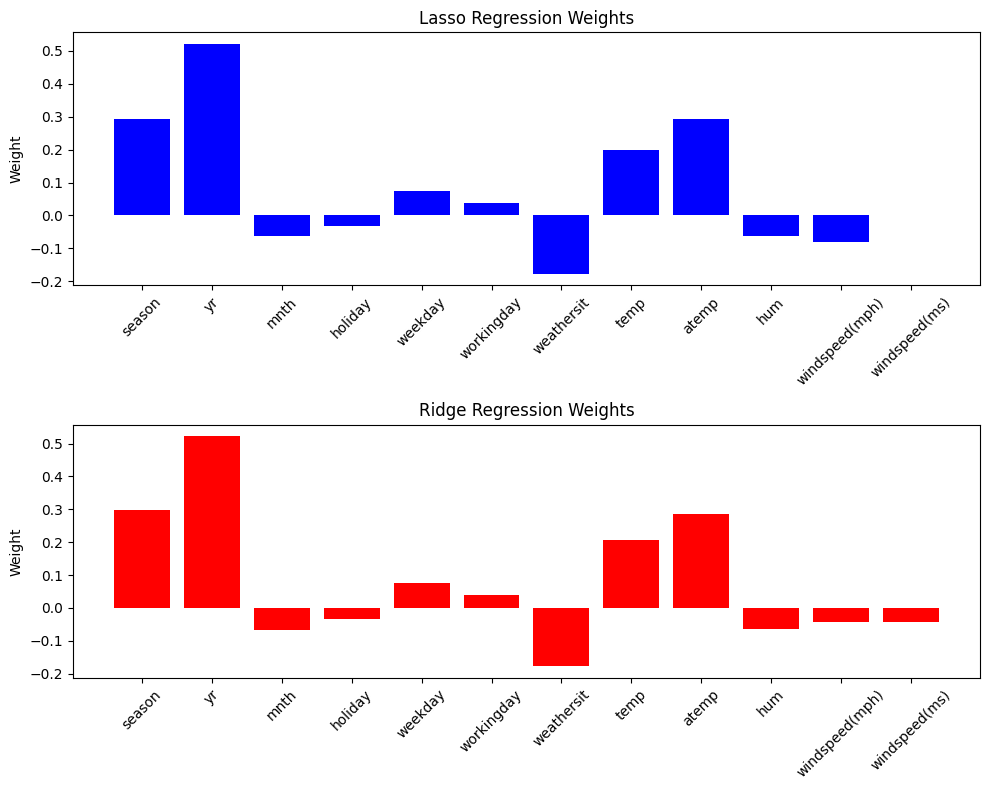

In [47]:
# Навчання моделі Ridge з параметрами за замовчуванням
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Виведення ваг ознак для Ridge
ridge_weights = zip(X.columns, ridge_model.coef_)
ridge_output = "Ваги ознак (Ridge):\n"
for feature, weight in ridge_weights:
    ridge_output += f"{feature}: {weight}\n"
print(ridge_output)

# Візуалізація моделей Lasso та Ridge
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Візуалізація Lasso
ax[0].bar(X.columns, lasso_model.coef_, color='blue')
ax[0].set_title('Lasso Regression Weights')
ax[0].set_ylabel('Weight')
ax[0].set_xticks(range(len(X.columns)))
ax[0].set_xticklabels(X.columns, rotation=45)

# Візуалізація Ridge
ax[1].bar(X.columns, ridge_model.coef_, color='red')
ax[1].set_title('Ridge Regression Weights')
ax[1].set_ylabel('Weight')
ax[1].set_xticks(range(len(X.columns)))
ax[1].set_xticklabels(X.columns, rotation=45)

plt.tight_layout()
plt.show()

### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

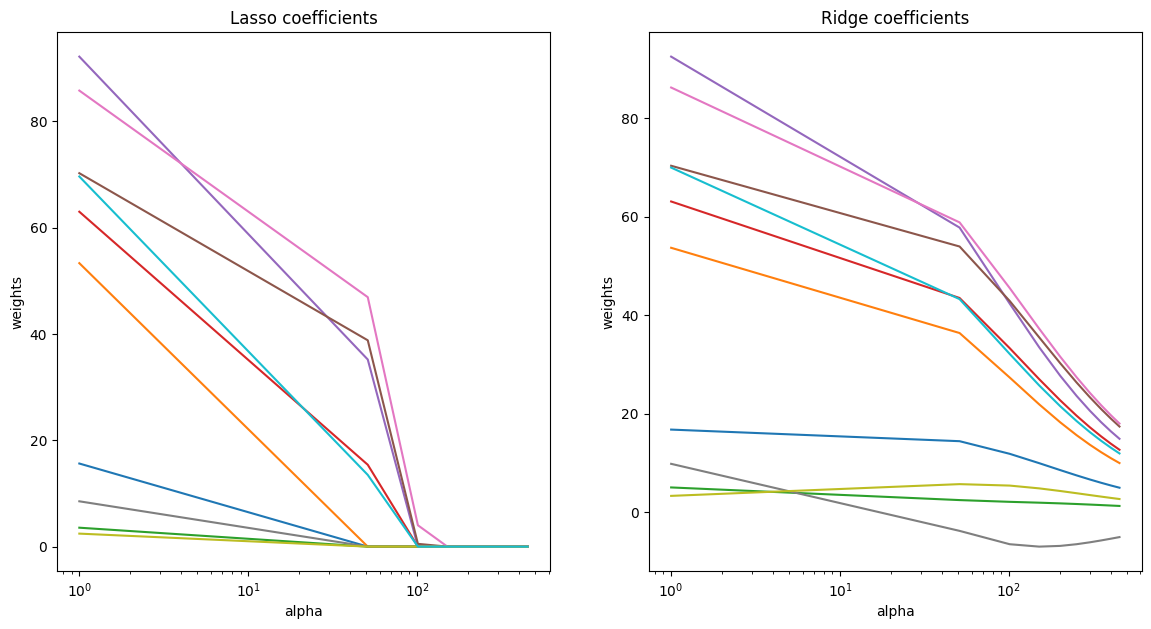

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.datasets import make_regression


# Створення синтетичних даних для регресії
X, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=42)

# Діапазон значень для коефіцієнта регуляризації α

alphas = np.arange(1, 500, 50)

# Списки для збереження ваг
coefs_lasso = []
coefs_ridge = []

# Навчання моделей для кожного значення α і збереження ваг
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    ridge = Ridge(alpha=alpha)
    lasso.fit(X, y)
    ridge.fit(X, y)
    coefs_lasso.append(lasso.coef_)
    coefs_ridge.append(ridge.coef_)

# Конвертація списків в np.array
coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

# Візуалізація ваг
plt.figure(figsize=(14, 7))

# Візуалізація ваг для Lasso
plt.subplot(1, 2, 1)
plt.plot(alphas, coefs_lasso)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients')
plt.axis('tight')

# Візуалізація ваг для Ridge
plt.subplot(1, 2, 2)
plt.plot(alphas, coefs_ridge)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients')
plt.axis('tight')

plt.show()

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

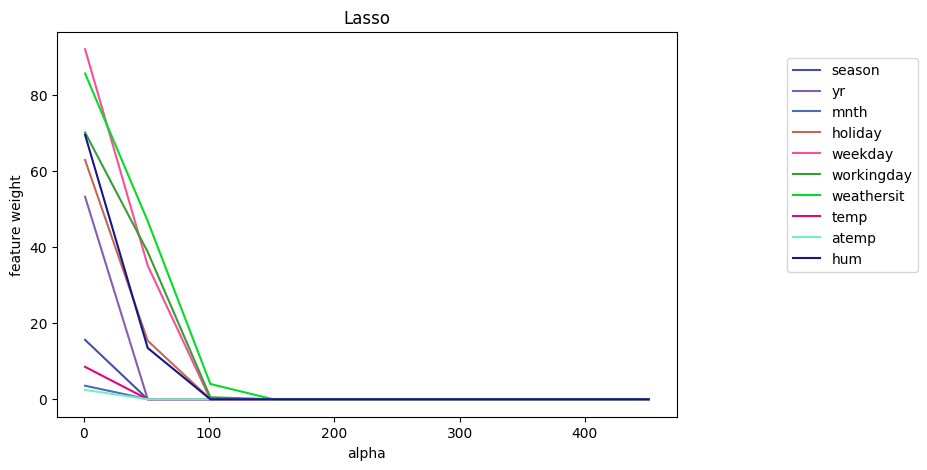

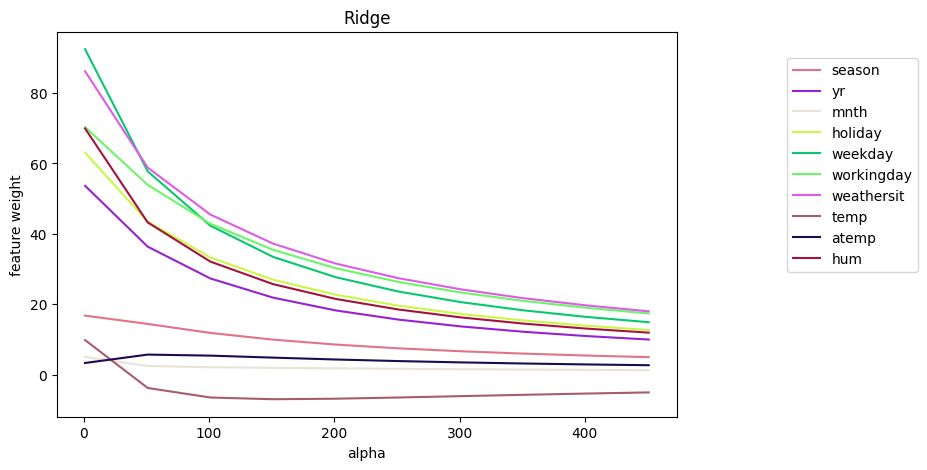

In [53]:

plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?

    **Lasso є більш агресивним регуляризатором у порівнянні з Ridge. Це видно з графіків, де при одному і тому ж значенні α ваги для Lasso швидше наближаються до нуля і деякі з них стають рівними нулю, тоді як ваги Ridge зменшуються поступово і не обнуляються.**

2. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.

    **Якщо α для Lasso зробити дуже великим, всі ваги стають рівними нулю. Це відбувається тому, що регуляризація Lasso (L1) накладає штраф, пропорційний абсолютному значенню ваги. При дуже великому α штраф стає настільки великим, що модель перетворює всі ваги на "0".**

3. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.

    **Lasso може виключати ознаки (зокрема, "windspeed") при певних значеннях 𝛼>0, але не обов'язково при всіх. При достатньо великому 𝛼 ваги для багатьох ознак можуть стати меншими за 10^{-3} або навіть рівними нулю.**
    
    **Ridge не виключає ознаки, оскільки його ваги зменшуються поступово і ніколи не стають точно рівними нулю. Навіть при великих значеннях α, ваги залишаються більшими за 10^{-3}, хоча і можуть бути дуже малими.**

4. Який із регуляризаторів підійде для відбору неінформативних ознак?

    **Lasso є кращим вибором для відбору неінформативних ознак. Це пов'язано з тим, що Lasso здатний обнулити ваги для менш важливих ознак, ефективно виключаючи їх з моделі. Таким чином, він може зменшити розмірність даних і зосередитись лише на найбільш інформативних ознаках.**

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [ ]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Вибране alpha: 1
Пари 'ознака-коефіцієнт':
season: 2.742458294975582
yr: 94.0739161216579
mnth: 19.533223233083675
holiday: 59.291056427706074
weekday: 39.08709514444928
workingday: 87.62293358525423
weathersit: 62.745549491428925
temp: -0.0
atemp: 21.314855417392845
hum: 59.53189131568368
windspeed(mph): 80.83478209101676
windspeed(ms): 0.0


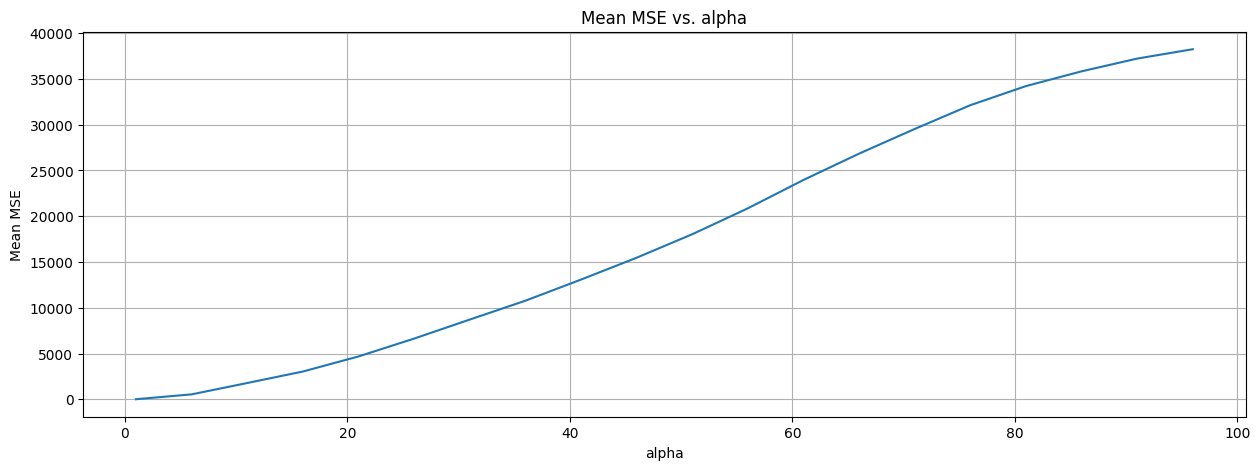

In [61]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import pandas as pd

# Створення синтетичних даних для регресії
X, y = make_regression(n_samples=100, n_features=12, noise=0.1, random_state=42)

# Визначення назв ознак
feature_names = [
    'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)'
]

# Створення DataFrame для назв ознак
df = pd.DataFrame(X, columns=feature_names)

# Діапазон значень для коефіцієнта регуляризації α
alphas = np.arange(1, 100, 5)

# Використання LassoCV для підбору найкращого α
lasso_cv = LassoCV(alphas=alphas, cv=3, max_iter=10000)
lasso_cv.fit(X, y)

# Виведення вибраного значення α
best_alpha = lasso_cv.alpha_
print(f'Вибране alpha: {best_alpha}')

# Виведення пар "ознака-коефіцієнт"
coef_pairs = list(zip(df.columns, lasso_cv.coef_))
print("Пари 'ознака-коефіцієнт':")
for feature, coef in coef_pairs:
    print(f'{feature}: {coef}')

# Побудова графіка усередненого за рядками MSE в залежності від α
mean_mse = lasso_cv.mse_path_.mean(axis=1)

def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x, y = zip(*data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

# Підготовка даних для графіка
data = list(zip(lasso_cv.alphas_, mean_mse))

# Побудова графіка
create_plot(data, 'Mean MSE vs. alpha', 'alpha', 'Mean MSE')



Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

Вибране alpha: 1
Пари 'ознака-коефіцієнт':
season: 15.62522637854795
yr: 53.301020112273726
mnth: 3.5587287791021365
holiday: 62.970793421511296
weekday: 92.13546661672629
workingday: 70.21647708649851
weathersit: 85.75021056293504
temp: 8.52167657958746
atemp: 2.44516793594375
hum: 69.59468306519487


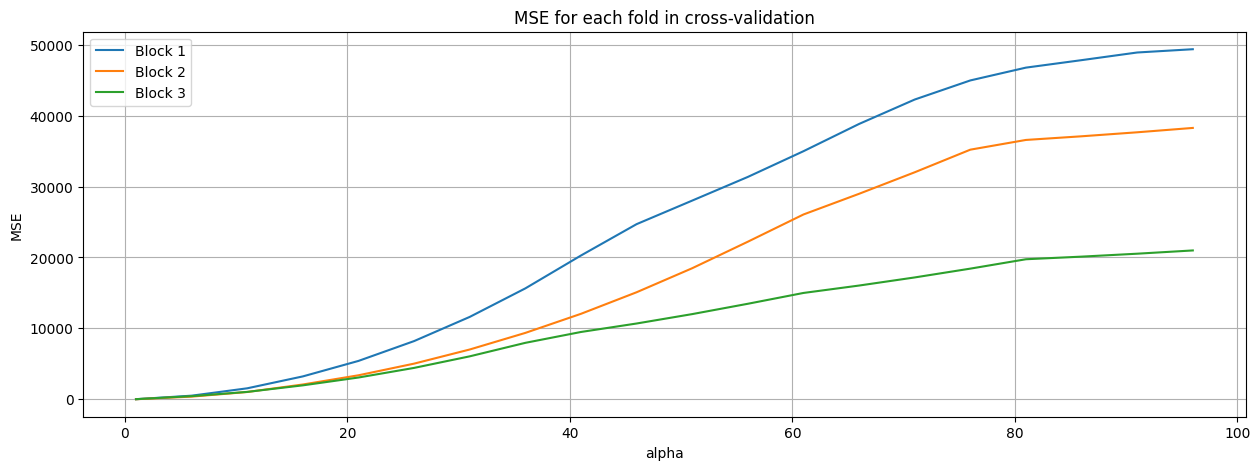

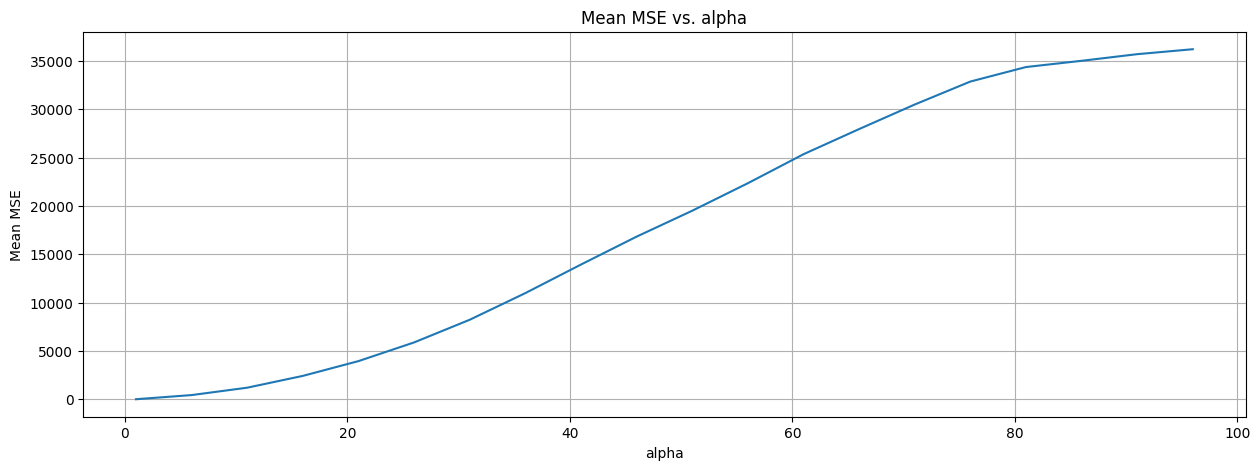

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import pandas as pd

# Створення синтетичних даних для регресії
X, y = make_regression(n_samples=100, n_features=10, noise=0.1, random_state=42)

# Визначення назв ознак
feature_names = [
    'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)'
]

# Створення DataFrame для назв ознак
df = pd.DataFrame(X, columns=feature_names[:X.shape[1]])

# Діапазон значень для коефіцієнта регуляризації α
alphas = np.arange(1, 100, 5)

# Використання LassoCV для підбору найкращого α
lasso_cv = LassoCV(alphas=alphas, cv=3, max_iter=10000)
lasso_cv.fit(X, y)

# Виведення вибраного значення α
best_alpha = lasso_cv.alpha_
print(f'Вибране alpha: {best_alpha}')

# Виведення пар "ознака-коефіцієнт"
coef_pairs = list(zip(df.columns, lasso_cv.coef_))
print("Пари 'ознака-коефіцієнт':")
for feature, coef in coef_pairs:
    print(f'{feature}: {coef}')

# Побудова графіка MSE для кожного окремого блоку
mse_path = lasso_cv.mse_path_

plt.figure(figsize=(15, 5))
for i in range(mse_path.shape[1]):
    plt.plot(lasso_cv.alphas_, mse_path[:, i], label=f'Block {i+1}')

plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('MSE for each fold in cross-validation')
plt.legend()
plt.grid(True)
plt.show()

# Побудова графіка усередненого за рядками MSE в залежності від α
mean_mse = mse_path.mean(axis=1)

def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x, y = zip(*data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

# Підготовка даних для графіка
data = list(zip(lasso_cv.alphas_, mean_mse))

# Побудова графіка
create_plot(data, 'Mean MSE vs. alpha', 'alpha', 'Mean MSE')


### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Вибране alpha: 1
Пари 'ознака-коефіцієнт':
season: 2.742458294975582
yr: 94.0739161216579
mnth: 19.533223233083675
holiday: 59.291056427706074
weekday: 39.08709514444928
workingday: 87.62293358525423
weathersit: 62.745549491428925
temp: -0.0
atemp: 21.314855417392845
hum: 59.53189131568368
windspeed(mph): 80.83478209101676
windspeed(ms): 0.0
Мінімум MSE на розбитті 1 відповідає alpha: 1
Мінімум MSE на розбитті 2 відповідає alpha: 1
Мінімум MSE на розбитті 3 відповідає alpha: 1


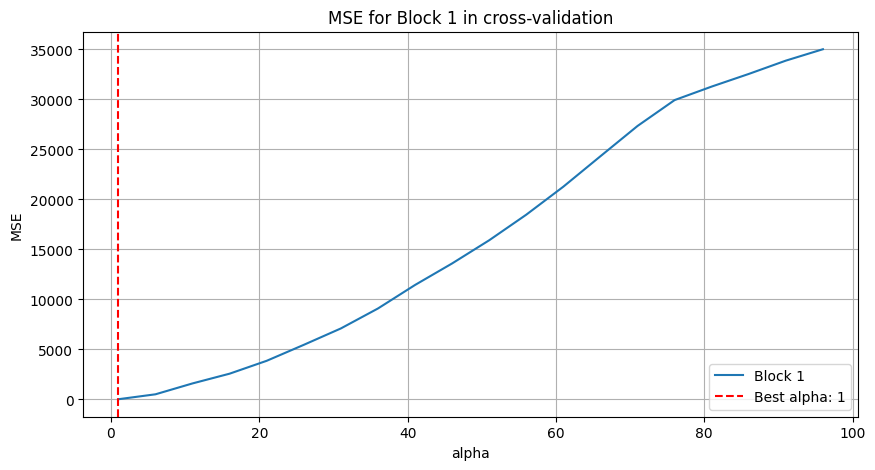

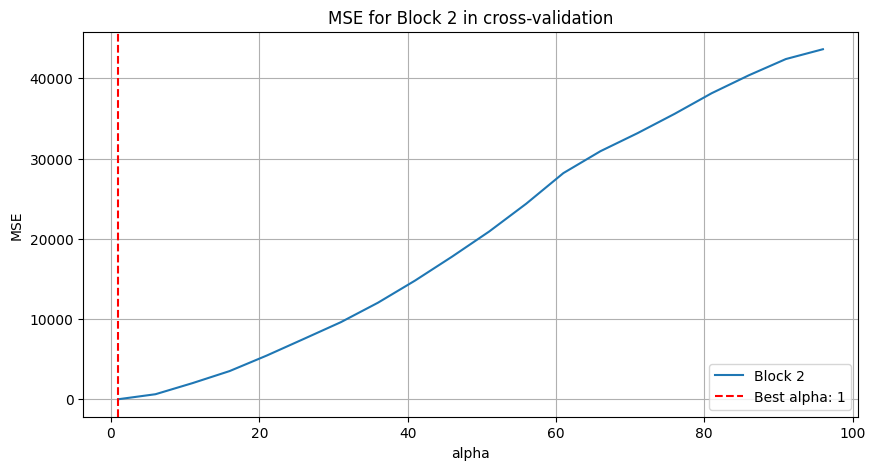

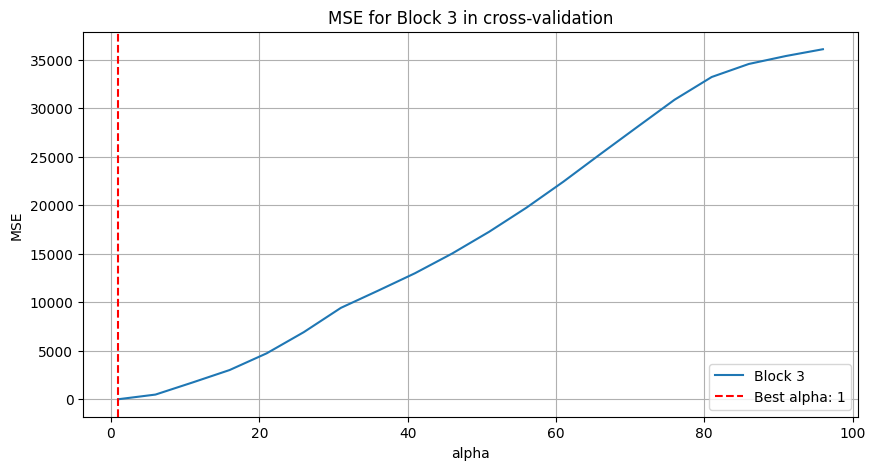

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
import pandas as pd

# Створення синтетичних даних для регресії
X, y = make_regression(n_samples=100, n_features=12, noise=0.1, random_state=42)

# Визначення назв ознак
feature_names = [
    'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)'
]

# Створення DataFrame для назв ознак
df = pd.DataFrame(X, columns=feature_names[:X.shape[1]])

# Діапазон значень для коефіцієнта регуляризації α
alphas = np.arange(1, 100, 5)

# Використання LassoCV для підбору найкращого α
lasso_cv = LassoCV(alphas=alphas, cv=3, max_iter=10000)
lasso_cv.fit(X, y)

# Виведення вибраного значення α
best_alpha = lasso_cv.alpha_
print(f'Вибране alpha: {best_alpha}')

# Виведення пар "ознака-коефіцієнт"
coef_pairs = list(zip(df.columns, lasso_cv.coef_))
print("Пари 'ознака-коефіцієнт':")
for feature, coef in coef_pairs:
    print(f'{feature}: {coef}')

# Побудова графіка MSE для кожного окремого блоку
mse_path = lasso_cv.mse_path_

# Знайти значення alpha, що відповідають мінімумам MSE на кожному розбитті
min_alphas = [lasso_cv.alphas_[np.argmin(mse_path[:, i])] for i in range(mse_path.shape[1])]
for i, alpha in enumerate(min_alphas):
    print(f'Мінімум MSE на розбитті {i+1} відповідає alpha: {alpha}')

# Побудова окремих графіків для кожного розбиття
for i in range(mse_path.shape[1]):
    plt.figure(figsize=(10, 5))
    plt.plot(lasso_cv.alphas_, mse_path[:, i], label=f'Block {i+1}')
    plt.axvline(x=min_alphas[i], color='r', linestyle='--', label=f'Best alpha: {min_alphas[i]}')
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.title(f'MSE for Block {i+1} in cross-validation')
    plt.legend()
    plt.grid(True)
    plt.show()


На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

"Стандартизована матриця об'єкти-ознаки:\n"

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,-1.348213,-1.001369,-1.600161,-0.171981,1.498809,-1.471225,1.110427,-0.826662,-0.679946,1.250171,-0.387892,-0.387892
1,-1.348213,-1.001369,-1.600161,-0.171981,-1.496077,-1.471225,1.110427,-0.721095,-0.740652,0.479113,0.749602,0.749602
2,-1.348213,-1.001369,-1.600161,-0.171981,-0.996930,0.679706,-0.726048,-1.634657,-1.749767,-1.339274,0.746632,0.746632
3,-1.348213,-1.001369,-1.600161,-0.171981,-0.497782,0.679706,-0.726048,-1.614780,-1.610270,-0.263182,-0.389829,-0.389829
4,-1.348213,-1.001369,-1.600161,-0.171981,0.001366,0.679706,-0.726048,-1.467414,-1.504971,-1.341494,-0.046307,-0.046307
...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.348213,0.998633,1.588660,-0.171981,0.500513,0.679706,1.110427,-1.318665,-1.521108,0.175807,2.061426,2.061426
727,-1.348213,0.998633,1.588660,-0.171981,0.999661,0.679706,1.110427,-1.323224,-1.346690,-0.266238,-0.452131,-0.452131
728,-1.348213,0.998633,1.588660,-0.171981,1.498809,-1.471225,1.110427,-1.323224,-1.424344,0.878392,-0.853552,-0.853552
729,-1.348213,0.998633,1.588660,-0.171981,-1.496077,-1.471225,-0.726048,-1.309558,-1.490049,-1.015664,2.069444,2.069444


Ваги ознак (Lasso):
season: 0.0
yr: -7.70542565284827e-06
mnth: -3.0262581103952616e-06
holiday: -2.8746808901115526e-05
weekday: -3.5801791622994056e-05
workingday: -1.4892916178309717e-05
weathersit: -1.4384907678072228e-05
temp: 0.005179267888224041
atemp: -0.005158307506914198
hum: 3.604531373606277e-05
windspeed(mph): 0.9998679196658024

Ваги ознак (Ridge):
season: -0.00017570746851046476
yr: -5.535624554778738e-05
temp: -9.372262630950584e-05
atemp: -4.614418238354847e-05



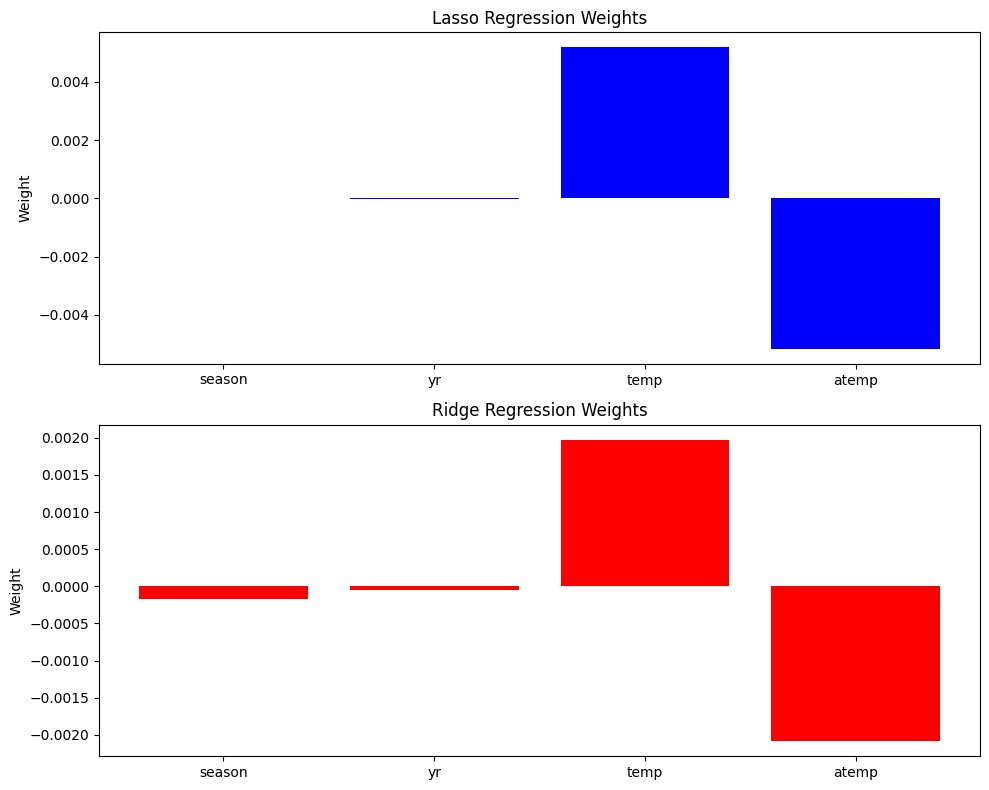

In [73]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Шлях до файлу на Google Drive
path = '/content/drive/My Drive/Colab Notebooks/HW_4/bikes_rent.csv'

# Читаємо CSV файл
df = pd.read_csv(path)

# Виводимо перші рядки DataFrame
df.head()

# Стандартизація ознак
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['cnt']))

# Перетворення назад у DataFrame для зручності
scaled_df = pd.DataFrame(scaled_data, columns=df.columns[:-1])  # Виключаємо 'cnt'
display("Стандартизована матриця об'єкти-ознаки:\n", scaled_df)

# Виділення ознак і цільової змінної
X = scaled_df.drop(columns=scaled_df.columns[-1])
y = scaled_df[scaled_df.columns[-1]]

# Розділення даних на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Навчання моделі Lasso з меншим параметром α
lasso_model = Lasso(alpha=0.000001)  # Зменшення параметра α
lasso_model.fit(X_train, y_train)

selected_features = ['season', 'yr', 'temp', 'atemp']

# Виведення ваг ознак для Lasso
lasso_weights = zip(X.columns, lasso_model.coef_)
lasso_output = "Ваги ознак (Lasso):\n"
for feature, weight in lasso_weights:
    lasso_output += f"{feature}: {weight}\n"
print(lasso_output)

# Навчання моделі Ridge з параметрами за замовчуванням
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Виведення ваг ознак для Ridge
ridge_weights = zip(selected_features, ridge_model.coef_)
ridge_output = "Ваги ознак (Ridge):\n"
for feature, weight in ridge_weights:
    ridge_output += f"{feature}: {weight}\n"
print(ridge_output)

# Візуалізація моделей Lasso та Ridge
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Візуалізація Lasso
lasso_selected_coefs = [lasso_model.coef_[X.columns.get_loc(f)] for f in selected_features]
ax[0].bar(selected_features, lasso_selected_coefs, color='blue')
ax[0].set_title('Lasso Regression Weights')
ax[0].set_ylabel('Weight')

# Візуалізація Ridge
ridge_selected_coefs = [ridge_model.coef_[X.columns.get_loc(f)] for f in selected_features]
ax[1].bar(selected_features, ridge_selected_coefs, color='red')
ax[1].set_title('Ridge Regression Weights')
ax[1].set_ylabel('Weight')

plt.tight_layout()
plt.show()

** В нашому прикладі доцільно стверджувати, що при збільшенні ваги параметрів "season","temp", "atemp" тим більше людей захочуть взяти велосипеди**

#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

"Стандартизована матриця об'єкти-ознаки:\n"

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,-1.348213,-1.001369,-1.600161,-0.171981,1.498809,-1.471225,1.110427,-0.826662,-0.679946,1.250171,-0.387892,4.805490
1,-1.348213,-1.001369,-1.600161,-0.171981,-1.496077,-1.471225,1.110427,-0.721095,-0.740652,0.479113,0.749602,7.443949
2,-1.348213,-1.001369,-1.600161,-0.171981,-0.996930,0.679706,-0.726048,-1.634657,-1.749767,-1.339274,0.746632,7.437060
3,-1.348213,-1.001369,-1.600161,-0.171981,-0.497782,0.679706,-0.726048,-1.614780,-1.610270,-0.263182,-0.389829,4.800998
4,-1.348213,-1.001369,-1.600161,-0.171981,0.001366,0.679706,-0.726048,-1.467414,-1.504971,-1.341494,-0.046307,5.597810
...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.348213,0.998633,1.588660,-0.171981,0.500513,0.679706,1.110427,-1.318665,-1.521108,0.175807,2.061426,10.486773
727,-1.348213,0.998633,1.588660,-0.171981,0.999661,0.679706,1.110427,-1.323224,-1.346690,-0.266238,-0.452131,4.656485
728,-1.348213,0.998633,1.588660,-0.171981,1.498809,-1.471225,1.110427,-1.323224,-1.424344,0.878392,-0.853552,3.725374
729,-1.348213,0.998633,1.588660,-0.171981,-1.496077,-1.471225,-0.726048,-1.309558,-1.490049,-1.015664,2.069444,10.505372


Ваги ознак (Lasso):
weathersit: 0.0
windspeed(ms): 0.9998136472734227
hum: -0.0

Ваги ознак (Ridge):
weathersit: 0.00025110201661592083
windspeed(ms): 0.9996379848133113
hum: -0.0003519804653372934



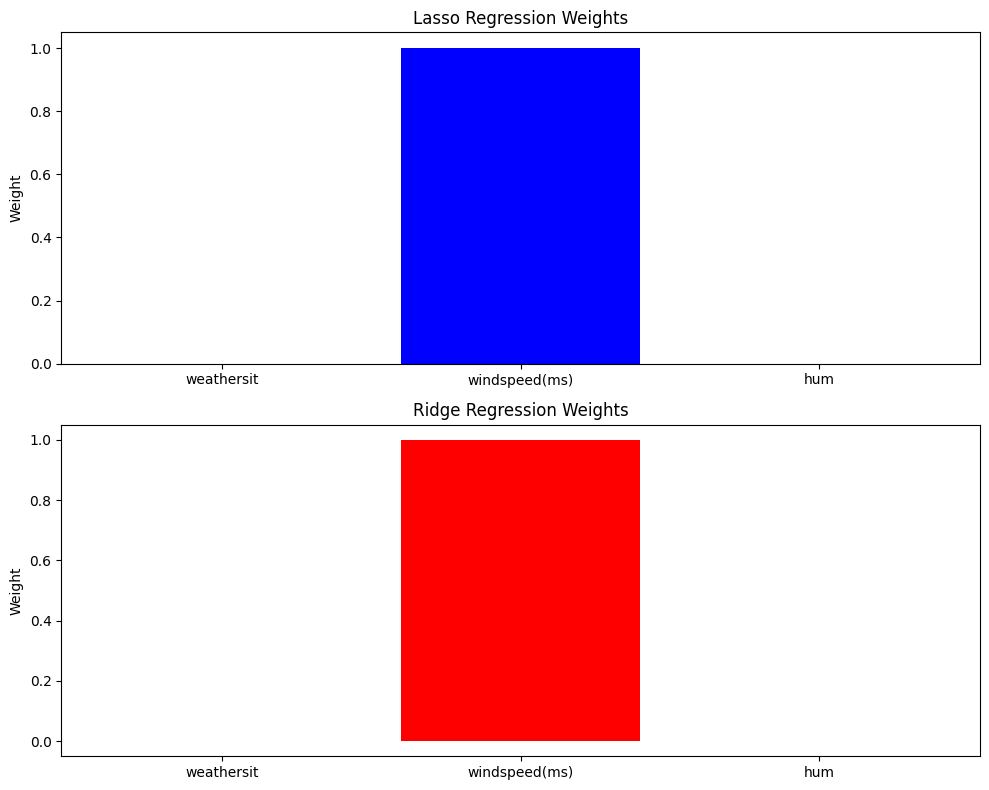

In [82]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Шлях до файлу на Google Drive
path = '/content/drive/My Drive/Colab Notebooks/HW_4/bikes_rent.csv'

# Читаємо CSV файл
df = pd.read_csv(path)

# Стандартизація ознак
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['cnt']))

# Перетворення назад у DataFrame для зручності
scaled_df = pd.DataFrame(scaled_data, columns=df.columns[:-1])  # Виключаємо 'cnt'
scaled_df['windspeed(ms)'] = df['windspeed(ms)']
display("Стандартизована матриця об'єкти-ознаки:\n", scaled_df)

# Виділення ознак і цільової змінної
X = scaled_df[selected_features]
y = scaled_df.iloc[:, -1]

# Розділення даних на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Навчання моделі Lasso з меншим параметром α
lasso_model = Lasso(alpha=0.001)  # Зменшення параметра α
lasso_model.fit(X_train, y_train)

# Виведення ваг ознак для Lasso
lasso_weights = zip(X.columns, lasso_model.coef_)
lasso_output = "Ваги ознак (Lasso):\n"
for feature, weight in lasso_weights:
    lasso_output += f"{feature}: {weight}\n"
print(lasso_output)

# Навчання моделі Ridge з параметрами за замовчуванням
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Виведення ваг ознак для Ridge
ridge_weights = zip(selected_features, ridge_model.coef_)
ridge_output = "Ваги ознак (Ridge):\n"
for feature, weight in ridge_weights:
    ridge_output += f"{feature}: {weight}\n"
print(ridge_output)

# Візуалізація моделей Lasso та Ridge
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Візуалізація Lasso
lasso_selected_coefs = [lasso_model.coef_[X.columns.get_loc(f)] for f in selected_features]
ax[0].bar(selected_features, lasso_selected_coefs, color='blue')
ax[0].set_title('Lasso Regression Weights')
ax[0].set_ylabel('Weight')

# Візуалізація Ridge
ridge_selected_coefs = [ridge_model.coef_[X.columns.get_loc(f)] for f in selected_features]
ax[1].bar(selected_features, ridge_selected_coefs, color='red')
ax[1].set_title('Ridge Regression Weights')
ax[1].set_ylabel('Weight')

plt.tight_layout()
plt.show()


У моделі Lasso бачимо, що ознаки weathersit та hum мають вагу близьку до нуля, що може означати їхню слабку або навіть відсутню важливість для прогнозування. Однак ознака windspeed(ms) має вагу близьку до 1, що означає великий вплив на прогноз.

У моделі Ridge ваги ознак є невеликими, але вони не до кінця нульові. Це означає, що модель враховує їхній внесок у прогноз, але не вважає їх настільки важливими, як windspeed(ms) у моделі Lasso.

Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__ насправді дані коефіціенти впливають на попит на велосипеди але їх вплив настільки не значний по відношенню до інших параметрів(ознак) що модель не бере до уваги вплив даних показників на загальну картину

"Стандартизована матриця об'єкти-ознаки:\n"

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
0,-1.348213,-1.001369,-1.600161,-0.171981,1.498809,-1.471225,1.110427,-0.826662,-0.679946,1.250171,-0.387892,-0.387892
1,-1.348213,-1.001369,-1.600161,-0.171981,-1.496077,-1.471225,1.110427,-0.721095,-0.740652,0.479113,0.749602,0.749602
2,-1.348213,-1.001369,-1.600161,-0.171981,-0.996930,0.679706,-0.726048,-1.634657,-1.749767,-1.339274,0.746632,0.746632
3,-1.348213,-1.001369,-1.600161,-0.171981,-0.497782,0.679706,-0.726048,-1.614780,-1.610270,-0.263182,-0.389829,-0.389829
4,-1.348213,-1.001369,-1.600161,-0.171981,0.001366,0.679706,-0.726048,-1.467414,-1.504971,-1.341494,-0.046307,-0.046307
...,...,...,...,...,...,...,...,...,...,...,...,...
726,-1.348213,0.998633,1.588660,-0.171981,0.500513,0.679706,1.110427,-1.318665,-1.521108,0.175807,2.061426,2.061426
727,-1.348213,0.998633,1.588660,-0.171981,0.999661,0.679706,1.110427,-1.323224,-1.346690,-0.266238,-0.452131,-0.452131
728,-1.348213,0.998633,1.588660,-0.171981,1.498809,-1.471225,1.110427,-1.323224,-1.424344,0.878392,-0.853552,-0.853552
729,-1.348213,0.998633,1.588660,-0.171981,-1.496077,-1.471225,-0.726048,-1.309558,-1.490049,-1.015664,2.069444,2.069444


Ваги ознак (Lasso):
mnth: -7.439144025116957e-06
holiday: -3.06434856540867e-05
weekday: -3.7197977382777654e-05
workingday: -1.62135314551246e-05

Ваги ознак (Ridge):
mnth: -0.00017570746851046476
holiday: -5.535624554778738e-05
weekday: -9.372262630950584e-05
workingday: -4.614418238354847e-05



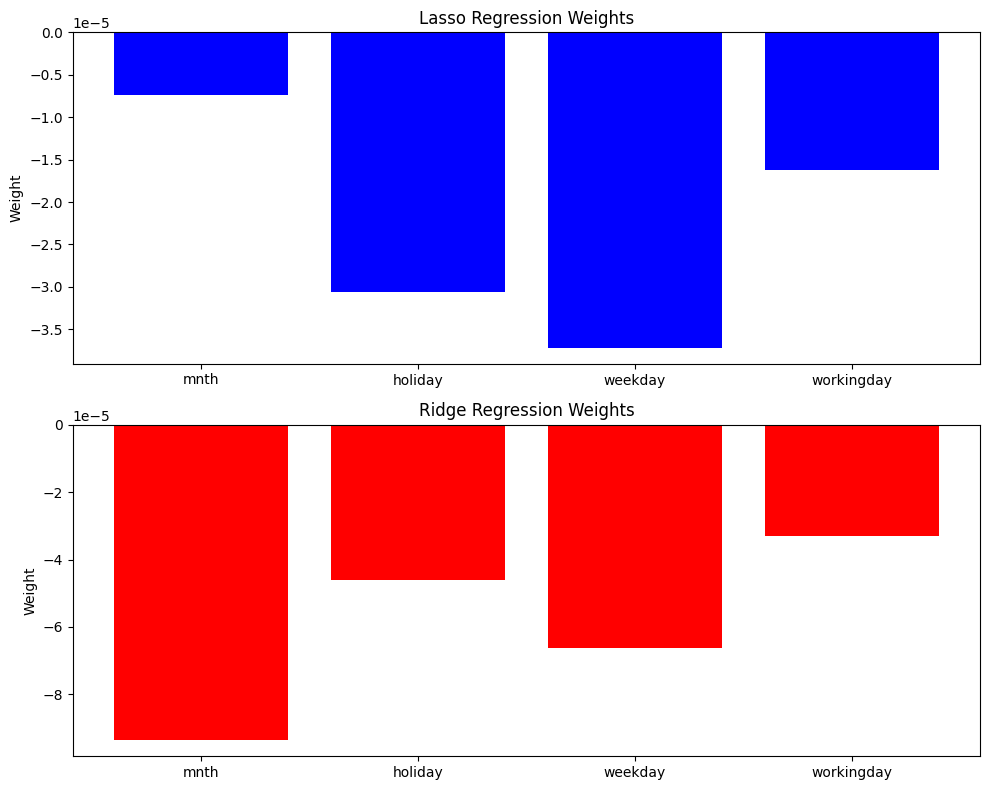

In [92]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Шлях до файлу на Google Drive
path = '/content/drive/My Drive/Colab Notebooks/HW_4/bikes_rent.csv'

# Читаємо CSV файл
df = pd.read_csv(path)

# Виводимо перші рядки DataFrame
df.head()

# Стандартизація ознак
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['cnt']))

# Перетворення назад у DataFrame для зручності
scaled_df = pd.DataFrame(scaled_data, columns=df.columns[:-1])  # Виключаємо 'cnt'
display("Стандартизована матриця об'єкти-ознаки:\n", scaled_df)

# Виділення ознак і цільової змінної
X = scaled_df.drop(columns=scaled_df.columns[-1])
y = scaled_df[scaled_df.columns[-1]]

# Розділення даних на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Навчання моделі Lasso з меншим параметром α
lasso_model = Lasso(alpha=0.000000001)  # Зменшення параметра α
lasso_model.fit(X_train, y_train)

selected_features = ['mnth', 'holiday', 'weekday', 'workingday']

# Виведення ваг ознак для Lasso
lasso_weights = zip(X.columns, lasso_model.coef_)
lasso_output = "Ваги ознак (Lasso):\n"
for feature, weight in lasso_weights:
    if feature in selected_features:
        lasso_output += f"{feature}: {weight}\n"
print(lasso_output)

# Навчання моделі Ridge з параметрами за замовчуванням
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Виведення ваг ознак для Ridge
ridge_weights = zip(selected_features, ridge_model.coef_)
ridge_output = "Ваги ознак (Ridge):\n"
for feature, weight in ridge_weights:
    ridge_output += f"{feature}: {weight}\n"
print(ridge_output)

# Візуалізація моделей Lasso та Ridge
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Візуалізація Lasso
lasso_selected_coefs = [lasso_model.coef_[X.columns.get_loc(f)] for f in selected_features]
ax[0].bar(selected_features, lasso_selected_coefs, color='blue')
ax[0].set_title('Lasso Regression Weights')
ax[0].set_ylabel('Weight')

# Візуалізація Ridge
ridge_selected_coefs = [ridge_model.coef_[X.columns.get_loc(f)] for f in selected_features]
ax[1].bar(selected_features, ridge_selected_coefs, color='red')
ax[1].set_title('Ridge Regression Weights')
ax[1].set_ylabel('Weight')

plt.tight_layout()
plt.show()

### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.